In [11]:
import os

while "src" not in os.listdir():
    assert os.getcwd() != "/"
    os.chdir("..")

import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from src.lib.util import convert_scaled_mse_to_m_mse

In [12]:
def load_histories(path):
    with open(path) as f:
        history = json.load(f)
    loss = history["loss"]
    val_loss = history["val_loss"]
    return loss, val_loss

def compare(df, names, labels=None, val=False, save_path=None):
    if labels is None:
        labels = names
    
    mean_loss = []
    std_loss = []
    if val:
        loss_suffix = "_mean_val_loss"
        std_suffix = "_std_val_loss"
    else:
        loss_suffix = "_mean_loss"
        std_suffix = "_std_loss"
    
    for name in names:
        mean_loss.append(df[name + loss_suffix])
        std_loss.append(df[name + std_suffix])
    mean_loss = np.array(mean_loss)
    std_loss = np.array(std_loss)


    plt.figure(figsize=(8, 5))

    for i in range(len(mean_loss)):
        plt.fill_between(range(len(mean_loss[i])), mean_loss[i] - std_loss[i], mean_loss[i] + std_loss[i], alpha=0.2)
        if "contrastive" in names[i]:
            plt.plot(mean_loss[i], label=labels[i], linestyle="--")
        else:
            plt.plot(mean_loss[i], label=labels[i])
        
    plt.legend()
    # give title and axis labels depending on val
    if val:
        plt.title("Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Validation MSE (m$^2$)")
    else:
        plt.title("Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Training MSE (m$^2$)")
        

    # gridlines
    plt.grid(True)


    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()

In [13]:
experiments_dir = "experiments"
experiment_names = os.listdir(experiments_dir)

experiment_paths = []
for name in experiment_names:
    experiment_paths.append(os.path.join(experiments_dir, name))

experiment_base_names = []
for path in experiment_names:
    experiment_base_names.append(path[:-2])

experiment_base_names = sorted(list(set(experiment_base_names)))

assert len(experiment_base_names) == 6
experiment_base_names

['classification_finetuning_bs64_lr0.0001_epochs70_dropout0.0',
 'classification_probing_bs64_lr0.0001_epochs70_dropout0.0',
 'classification_switch_bs64_lr0.0001_epochs70_dropout0.0',
 'contrastive_finetuning_bs64_lr0.0001_epochs70_dropout0.0',
 'contrastive_probing_bs64_lr0.0001_epochs70_dropout0.0',
 'contrastive_switch_bs64_lr0.0001_epochs70_dropout0.0']

In [14]:
experiment_map = {}
# experiment_map:
#   key: experiment name
#   value: list of tuples (loss, val_loss)

for name in experiment_base_names:
    experiment_map[name] = []
    for path in experiment_paths:
        if name in path:
            loss, val_loss = load_histories(os.path.join(path, "histories.json"))
            loss = list(map(convert_scaled_mse_to_m_mse, loss))
            val_loss = list(map(convert_scaled_mse_to_m_mse, val_loss))
            experiment_map[name].append((loss, val_loss))
        
# results_df:
#   columns: experiment_name_mean_loss, experiment_name_std_loss, experiment_name_mean_val_loss, experiment_name_std_val_loss
#   index: epochs
results_df = pd.DataFrame()
for name in experiment_base_names:
    losses = []
    val_losses = []
    for loss, val_loss in experiment_map[name]:
        losses.append(loss)
        val_losses.append(val_loss)
    losses = np.array(losses)
    val_losses = np.array(val_losses)
    results_df[name + "_mean_loss"] = np.mean(losses, axis=0)
    results_df[name + "_std_loss"] = np.std(losses, axis=0)
    results_df[name + "_mean_val_loss"] = np.mean(val_losses, axis=0)
    results_df[name + "_std_val_loss"] = np.std(val_losses, axis=0)

results_df

,classification_finetuning_bs64_lr0.0001_epochs70_dropout0.0_mean_loss,classification_finetuning_bs64_lr0.0001_epochs70_dropout0.0_std_loss,classification_finetuning_bs64_lr0.0001_epochs70_dropout0.0_mean_val_loss,classification_finetuning_bs64_lr0.0001_epochs70_dropout0.0_std_val_loss,classification_probing_bs64_lr0.0001_epochs70_dropout0.0_mean_loss,classification_probing_bs64_lr0.0001_epochs70_dropout0.0_std_loss,classification_probing_bs64_lr0.0001_epochs70_dropout0.0_mean_val_loss,classification_probing_bs64_lr0.0001_epochs70_dropout0.0_std_val_loss,classification_switch_bs64_lr0.0001_epochs70_dropout0.0_mean_loss,classification_switch_bs64_lr0.0001_epochs70_dropout0.0_std_loss,...,contrastive_finetuning_bs64_lr0.0001_epochs70_dropout0.0_mean_val_loss,contrastive_finetuning_bs64_lr0.0001_epochs70_dropout0.0_std_val_loss,contrastive_probing_bs64_lr0.0001_epochs70_dropout0.0_mean_loss,contrastive_probing_bs64_lr0.0001_epochs70_dropout0.0_std_loss,contrastive_probing_bs64_lr0.0001_epochs70_dropout0.0_mean_val_loss,contrastive_probing_bs64_lr0.0001_epochs70_dropout0.0_std_val_loss,contrastive_switch_bs64_lr0.0001_epochs70_dropout0.0_mean_loss,contrastive_switch_bs64_lr0.0001_epochs70_dropout0.0_std_loss,contrastive_switch_bs64_lr0.0001_epochs70_dropout0.0_mean_val_loss,contrastive_switch_bs64_lr0.0001_epochs70_dropout0.0_std_val_loss
0,1.717149,0.148252,1.129101,0.249588,2.361692,0.159694,1.666511,0.183539,2.492416,0.407772,...,1.504745,0.433593,2.987016,0.454550,1.943065,0.535914,2.772007,0.322062,1.859439,0.397189
1,0.927584,0.055063,0.816607,0.076864,1.578261,0.115271,1.286771,0.156619,1.549731,0.190346,...,1.105873,0.066528,2.012813,0.749435,1.544922,0.787998,1.835879,0.301384,1.280309,0.139908
2,0.798172,0.114891,0.744468,0.047825,1.356423,0.102330,1.173594,0.068377,1.303510,0.070343,...,0.848354,0.062818,1.740972,0.746790,1.455654,0.567915,1.371522,0.097049,1.096499,0.059041
3,0.649436,0.053370,0.680024,0.047691,1.230191,0.051904,1.125178,0.052139,1.251391,0.066113,...,0.826773,0.043245,1.390849,0.307146,1.148483,0.093189,1.210962,0.041024,1.053637,0.070124
4,0.570203,0.028128,0.656354,0.083480,1.161402,0.027733,1.013284,0.049901,1.230973,0.117750,...,0.794238,0.033834,1.217398,0.136544,1.118448,0.151107,1.140586,0.048846,0.974828,0.052738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.180445,0.020503,0.423335,0.039877,0.725670,0.040378,0.712176,0.045089,0.238299,0.021046,...,0.425213,0.028634,0.699354,0.069515,0.851459,0.075304,0.292561,0.010203,0.535353,0.021727
66,0.194420,0.063156,0.443048,0.064966,0.710926,0.008955,0.725784,0.048631,0.233472,0.012035,...,0.477820,0.070421,0.696058,0.054913,0.878041,0.100007,0.288945,0.009086,0.546195,0.008079
67,0.189234,0.051505,0.384182,0.022031,0.688008,0.030244,0.742057,0.050308,0.235094,0.007321,...,0.458147,0.026725,0.682284,0.038771,0.779811,0.030233,0.286938,0.008953,0.544939,0.046651
68,0.163690,0.016677,0.390433,0.014243,0.705535,0.034053,0.733322,0.047662,0.238665,0.016066,...,0.429089,0.011204,0.655971,0.013698,0.876936,0.063376,0.288767,0.021257,0.568461,0.041435


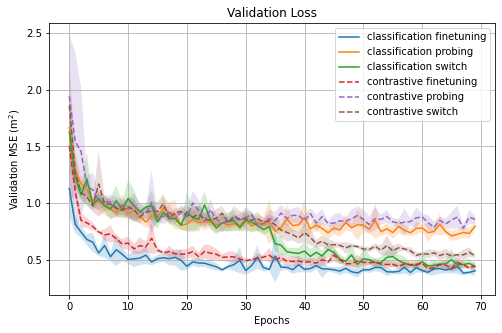

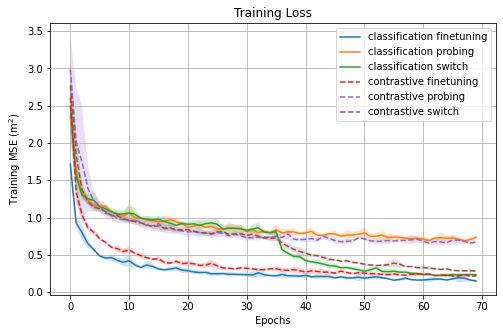

In [15]:
labels = ["%s %s" % tuple(name.split("_")[:2]) for name in experiment_base_names]

compare(results_df, experiment_base_names, labels, val=True, save_path="results/val_loss.png")
compare(results_df, experiment_base_names, labels, val=False, save_path="results/loss.png")